# Машинное обучение в бизнесе

## Урок 2. Профилирование пользователей. Сегментация: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

#### Ссылки
1. http://www.machinelearning.ru/wiki/images/d/d5/Voron17survey-artm.pdf
2. https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation

#### Библиотеки, которые нужно установить:

1. gensim
2. razdel
3. pymorphy2
4. nltk

#### Дополнительно, библиотеки для анализа текста
1. spacy 
2. natasha
3. nltk

## <center> Практическое задание </center>

### Реализация из методички webinar2.ipynb

In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


__Установка модуля gensim__

In [4]:
# pip install -i https://pypi.tuna.tsinghua.edu.cn/simple gensim

In [5]:
pip install gensim

In [6]:
pip install razdel

In [7]:
pip install pymorphy2

In [8]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


### 1. Получаем векторные представления новостей
(нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей)

In [9]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [10]:
#предобработка текстов
import re
import numpy as np
#import nltk
from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()  # Важно. Используется в функцие lemmatization()

In [13]:
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [14]:
stopword_ru[0:5]

['и', 'в', 'во', 'не', 'что']

In [15]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]
 
    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [16]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

<ipython-input-15-1a46d9e6ad2a>:15: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


Wall time: 27.4 s


In [17]:
%%time
#Запускаем лемматизацию текста (привидение слов к нормальной форме). Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 3min 39s


__Обучим нашу модель__

In [18]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, год, тропический, углеродный, цикл...
26999    [жить, примерно, тыс, год, назад, территория, ...
Name: title, Length: 27000, dtype: object

In [19]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [20]:
# common_dictionary[10]

In [21]:
# common_corpus[:1]

Запускаем обучение

In [22]:
from gensim.models import LdaModel 

In [23]:
# Train and use Online Latent Dirichlet Allocation model as presented in `'Online Learning for LDA' by Hoffman et al.`_

In [24]:
# LdaModel?

In [25]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 36.5 s


In [26]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [27]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(17, 0.29753998), (19, 0.5863112), (24, 0.09648261)]

In [28]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: температура памятник градус конструкция обвинение ст модернизация
topic_1: гражданин россиянин фронт народный ск знаменитый предупредить
topic_2: который год это также nn человек правительство
topic_3: это год компания который россия российский банк
topic_4: ракета запуск блок год запустить лауреат источник
topic_5: вуз индия снятие лесной молдавия молдавский казак
topic_6: год это который сша страна свой мочь
topic_7: мужчина женщина задержать сотрудник полиция след полицейский
topic_8: украина украинский рак белоруссия киев россия белорусский
topic_9: год млрд рубль возраст ребёнок болезнь вырасти
topic_10: газ млн космос район энергия налог граница
topic_11: наука квартира километр отдых клинический гражданин профессия
topic_12: который обнаружить год человек тело смерть время
topic_13: рейтинг место подсчитать nn партия мэй сведение
topic_14: путин фонд суд nn владимир президент россия
topic_15: методика терминал музыка студия передовой жуковский болид
topic_16: агентство 

Напишем функцию, которая будет нам возвращать векторное представление новости

In [29]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [30]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.574574,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.107578,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
1,4896,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.224988,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
2,4897,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.297784,0.0,0.586199,0.0,0.0,0.000000,0.0,0.096351
3,4898,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.129019,0.0,0.811048,0.0,0.0,0.000000,0.0,0.000000
4,4899,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.738386,0.0,0.000000


Мы получили вектора наших новостей.

## <center> Практическое задание </center>

Задание выполнил: Соковнин И.Л.

## 2. Задача:

- Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. 
- Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score 
- (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

#### 2.1 Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. 

In [31]:
# Embed
# - встраивать;
# - вставлять (insert, inset, interpose, paste, embed, plug);
# - врезать (embed, imbed, cut in, fit in);
# - внедрять (embed, root, intrude, inculcate, implant, plant)

# Evaluate
# - оценивать (evaluate, estimate, appreciate, assess, rate, measure)
# - иметь значение (matter, mean, signify, count, evaluate, weigh)
# - определять качество (evaluate)
# - определять количество (quantify, evaluate)
# - выражать в цифрах/числах (evaluate)

In [32]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [33]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [34]:
doc_dict[293622]

array([0.        , 0.06837386, 0.13480498, 0.08305722, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.15364261, 0.04918684, 0.06565096,
       0.        , 0.        , 0.131144  , 0.08228929, 0.16089033,
       0.        , 0.0181005 , 0.        , 0.04435834, 0.        ])

In [35]:
user_articles_list = users['articles'].iloc[33]
print(user_articles_list)

[323329, 321961, 324743, 323186, 324632, 474690]


### Векторные представления пользователей

In [36]:
# Вариант из методического пособия
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

In [37]:
# Модифицированный вариант
def get_user_embedding_type(user_articles_list, user_vector_type = 'mean'):
    '''Получаем векторное представление пользователя.
    
       Модифициуем код функции get_user_embedding таким образом,
       чтобы считалось не только среднее (как в примере np.mean), а медиана, max, ....'''
    
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # user_vector = np.mean(user_vector, 0)
    # print(user_vector, type(user_vector))
    
    if user_vector_type == 'median':
        user_vector = np.median(user_vector, 0)
    elif user_vector_type == 'max':
        user_vector = np.max(user_vector, axis=0)
    else:
        user_vector = np.mean(user_vector, 0)
   
    return user_vector

In [38]:
print(user_articles_list)

[323329, 321961, 324743, 323186, 324632, 474690]


In [39]:
get_user_embedding_type(user_articles_list, 'median')

array([0.        , 0.        , 0.14193447, 0.13349935, 0.        ,
       0.        , 0.17847174, 0.00699632, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.1179443 ,
       0.        , 0.        , 0.        , 0.03325877, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [40]:
# get_user_embedding_type(user_articles_list, 'max')

In [41]:
def get_user_embeddings (x, user_vector_type = 'mean'):
    '''Получаем эмбединги для всех пользователей'''
    
    our_user_embeddings = \
            pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_type(x, user_vector_type), 1)])
    
    our_user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
    our_user_embeddings['uid'] = users['uid'].values
    our_user_embeddings = our_user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]

    return our_user_embeddings

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [42]:
vector_type = 'median'  # используем медиану
user_embeddings = get_user_embeddings (users, vector_type)
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.006108,0.157533,0.078498,0.0,0.0,0.040609,0.0,0.000000,...,0.0,0.0,0.089925,0.018296,0.000000,0.0,0.0,0.000000,0.016376,0.000000
1,u108690,0.0,0.000000,0.102659,0.118759,0.0,0.0,0.189207,0.0,0.053513,...,0.0,0.0,0.000000,0.000000,0.103921,0.0,0.0,0.000000,0.039343,0.000000
2,u108339,0.0,0.000000,0.265919,0.082029,0.0,0.0,0.135653,0.0,0.000000,...,0.0,0.0,0.000000,0.031848,0.017687,0.0,0.0,0.068428,0.039628,0.009427


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

#### 2.2 Применить такое преобразование к данным, обучить модель прогнозирования оттока

In [43]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [44]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.006108,0.157533,0.078498,0.0,0.0,0.040609,0.0,0.000000,...,0.0,0.089925,0.018296,0.000000,0.0,0.0,0.000000,0.016376,0.000000,0
1,u108690,0.0,0.000000,0.102659,0.118759,0.0,0.0,0.189207,0.0,0.053513,...,0.0,0.000000,0.000000,0.103921,0.0,0.0,0.000000,0.039343,0.000000,1
2,u108339,0.0,0.000000,0.265919,0.082029,0.0,0.0,0.135653,0.0,0.000000,...,0.0,0.000000,0.031848,0.017687,0.0,0.0,0.068428,0.039628,0.009427,1


In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [46]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [47]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [48]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.18582835, 0.07787436, 0.41955981, 0.09151476, 0.1812798 ,
       0.05764356, 0.08015602, 0.20253787, 0.07633282, 0.1210316 ])

In [49]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

#### 2.3 Посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

### Рассчитаем ROC AUC

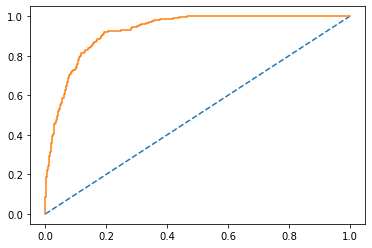

In [50]:
# roc curve
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot

# keep probabilities for the positive outcome only
# probs = predicted
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, preds)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr)
# show the plot
pyplot.show()

# https://www.machinelearningmastery.ru/how-to-score-probability-predictions-in-python/

In [51]:
# вычисляем roc auc
auc= roc_auc_score(y_test, preds)
print("AUC&ROC", auc)

AUC&ROC 0.9268469097040526


### Рассчитаем Precision, Recall, F_score (для них - подберём оптимальный порог с помощью precision_recall_curve)

In [52]:
import itertools

In [53]:
# thresholds - пороги
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.220256, F-Score=0.622, Precision=0.548, Recall=0.718


In [54]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1610  145]
 [  70  175]]


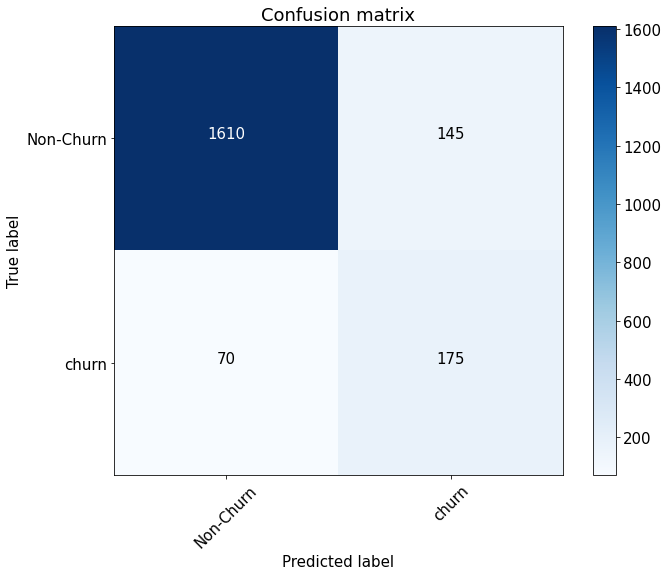

In [55]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [56]:
metrics = []
metric = {}
metric = {'embedding_method': vector_type,
          'AUC&ROC': auc,
          'F-Score': fscore[ix],
          'Precision': precision[ix],
          'Recall': recall[ix],
          'Best Threshold': thresholds[ix]
         }

metrics.append(metric)
metrics

[{'embedding_method': 'median',
  'AUC&ROC': 0.9268469097040526,
  'F-Score': 0.6219081272084805,
  'Precision': 0.5482866043613707,
  'Recall': 0.7183673469387755,
  'Best Threshold': 0.2202558068894556}]

# 

## 3. Задача:

- Повторить п.2, но используя уже не медиану, а max

__Получим эмбединги для всех пользователей используя в качестве метода получения эмбедингов пользователей: max.__


In [57]:
vector_type = 'max'  # используем max
user_embeddings = get_user_embeddings (users, vector_type)
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.069145,0.068374,0.324844,0.231510,0.032029,0.000000,0.546084,0.038634,0.293212,...,0.0,0.072366,0.275245,0.114211,0.160890,0.0,0.018101,0.169775,0.217592,0.093588
1,u108690,0.000000,0.000000,0.358332,0.291246,0.000000,0.023071,0.489133,0.062145,0.163812,...,0.0,0.037531,0.000000,0.076602,0.316281,0.0,0.013931,0.017237,0.089484,0.059549
2,u108339,0.021021,0.027548,0.368009,0.246488,0.000000,0.000000,0.466220,0.054050,0.000000,...,0.0,0.029548,0.059736,0.087030,0.067557,0.0,0.022501,0.111985,0.073087,0.173080


Применить преобразование к данным и обучим модель прогнозирования оттока

In [58]:
# target = pd.read_csv("users_churn.csv")
# target.head(3)

In [59]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.069145,0.068374,0.324844,0.231510,0.032029,0.000000,0.546084,0.038634,0.293212,...,0.072366,0.275245,0.114211,0.160890,0.0,0.018101,0.169775,0.217592,0.093588,0
1,u108690,0.000000,0.000000,0.358332,0.291246,0.000000,0.023071,0.489133,0.062145,0.163812,...,0.037531,0.000000,0.076602,0.316281,0.0,0.013931,0.017237,0.089484,0.059549,1
2,u108339,0.021021,0.027548,0.368009,0.246488,0.000000,0.000000,0.466220,0.054050,0.000000,...,0.029548,0.059736,0.087030,0.067557,0.0,0.022501,0.111985,0.073087,0.173080,1


In [60]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [61]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [62]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.09309904, 0.00947164, 0.77146497, 0.0537512 , 0.06772973,
       0.00503769, 0.12202224, 0.09934771, 0.06245985, 0.10298655])

### Рассчитаем ROC AUC

In [63]:
# вычисляем roc auc
auc= roc_auc_score(y_test, preds)
print("AUC&ROC", auc)

AUC&ROC 0.9680981452410025


### Рассчитаем Precision, Recall, F_score (для них - подберём оптимальный порог с помощью precision_recall_curve)

In [64]:
# thresholds - пороги
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.317380, F-Score=0.751, Precision=0.717, Recall=0.788


In [65]:
# Добавим результат в наш список
metric = {'embedding_method': vector_type,
          'AUC&ROC': auc,
          'F-Score': fscore[ix],
          'Precision': precision[ix],
          'Recall': recall[ix],
          'Best Threshold': thresholds[ix]
         }

metrics.append(metric)
# metrics

<br>__Повторим п.2, но используя уже не медиану, а mean__

In [66]:
vector_type = 'mean'  # используем mean
user_embeddings = get_user_embeddings (users, vector_type)
X = pd.merge(user_embeddings, target, 'left')

In [67]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [68]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [69]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]

In [70]:
# вычисляем roc auc
auc= roc_auc_score(y_test, preds)

In [71]:
# thresholds - пороги
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.588505, F-Score=nan, Precision=0.000, Recall=0.000


<ipython-input-71-a94ab27aef54>:3: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


In [72]:
# Добавим результат в наш список
metric = {'embedding_method': vector_type,
          'AUC&ROC': auc,
          'F-Score': fscore[ix],
          'Precision': precision[ix],
          'Recall': recall[ix],
          'Best Threshold': thresholds[ix]
         }

metrics.append(metric)
# metrics

## 4. Задача:

- (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.

## 5. Задача:

- Сформировать на выходе единую таблицу, сравнивающую качество 3 разных методов получения эмбедингов пользователей:<br>
    __mean, median, max, idf_mean__ по метрикам __roc_auc, precision, recall, f_score__

In [73]:
import pandas as pd
  
df = pd.DataFrame(metrics).sort_index().sort_values('Recall', kind='mergesort')

In [74]:
# df.iloc[:]

In [75]:
df.set_index('embedding_method', inplace=True)
df.sort_values('F-Score')

,AUC&ROC,F-Score,Precision,Recall,Best Threshold
embedding_method,,,,,
median,0.926847,0.621908,0.548287,0.718367,0.220256
max,0.968098,0.750973,0.717472,0.787755,0.317380
mean,0.921581,NaN,0.000000,0.000000,0.588505


## 6. Задача:

- Сделать самостоятельные выводы и предположения о том, почему тот или иной способ оказался эффективнее остальных

1. В нашем конкретном случае, использование метода получения эмбедингов пользователей __mean__ (среднее арифметическое), при величине порога
- $Best Threshold=0.2220$

   дало самые низкие значения метрик качества модели:
   
   
- $AUC\&ROC=0.912$,
- $F-Score=0.58$,
- $Precision=0.51$,
- $Recall=0.677$,<br>

  Значения метрик и порога, близки аналогичным значениям при использовании метода __median__, при этом порог близок, к порогу при использовании метода __median (0.20360)__ и значительно отличаются, от значения порога и метрик полученных при использовании метода __max (Best Threshold=0.328986)__.

2. Использование метода получения эмбедингов пользователей __median__ (медианы), дало средние значения метрик качества модели, близкие к значениям __mean__:


- $AUC\&ROC=0.9326$,
- $F-Score=0.64$,
- $Precision=0.54$,
- $Recall=0.7918$,

  при величине порога
  
  
- $Best Threshold=0.2036$.

  Значения метрик и порога, близки аналогичным значениям при использовании __mean__ и значительно отличаются, от значения порога и метрик полученных при использовании метода __max (Best Threshold=0.328986)__.

3. Использование метода получения эмбедингов пользователей __max__, дало самые высокие значения метрик качества модели, значительно отличающиеся от значений полученных при использовании метода __mean__:
- $AUC\&ROC=0.9594$,
- $F-Score=0.72$,
- $Precision=0.7027$,
- $Recall=0.7428$.

  При этом порог значительно отличается от аналогичных значений порога полученных при использовании методов __mean__ и __midean__
  

- $Best Threshold=0.3289$.


Такое расхождение в значениях метрик и порога, при использовании методов __mean__ и __midian__ и использовании метода __max__, можно объяснить присутствием __определённых (реперных) тем__ в векторе пользователя, наличие которых, является индикаторами того, что он покинет данный ресурс.

Метод __max__ сразу показывает эти темы, в то время как __mean__ и __midian__ сглаживают их наличие.